<a href="https://colab.research.google.com/github/JunSeokCheon/kaggle_house-prices_data_analysis/blob/master/house_price_feature_Engineering%26Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/kaggle_study/house_prices

/content/drive/MyDrive/kaggle_study/house_prices


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math

# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

### train/test 합쳐서 처리하는 대신 train/test 데이터 표시

In [6]:
c_test = df_test.copy()
c_train = df_train.copy()

In [7]:
c_train['train'] = 1
c_test['train'] = 0
df = pd.concat([c_train, c_test], axis = 0, sort=False)

In [8]:
df.shape

(2919, 82)

### 타겟변수 SalePrice 정규분포화 

Skewness : 1.882876
Kurtosis : 6.536282


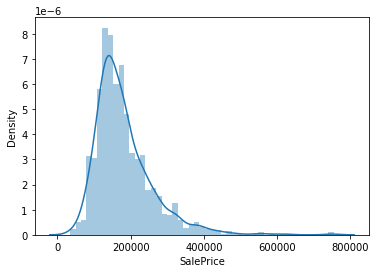

In [9]:
sns.distplot(df['SalePrice'])

print("Skewness : %f" % df['SalePrice'].skew())
print("Kurtosis : %f" % df['SalePrice'].kurt())

((array([-3.49454834, -3.25034572, -3.11527604, ...,  3.11527604,
          3.25034572,  3.49454834]),
  array([34900., 35311., 37900., ...,    nan,    nan,    nan])),
 (nan, nan, nan))

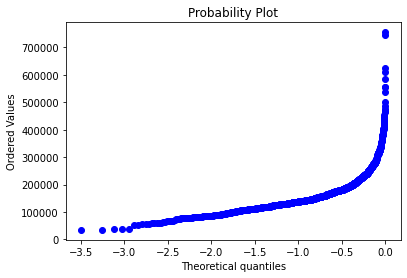

In [10]:
stats.probplot(df['SalePrice'], plot=plt)

Skewness : 0.121347
Kurtosis : 0.809519


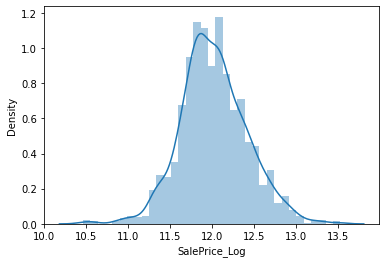

In [11]:
df['SalePrice_Log'] = np.log1p(df['SalePrice'])

sns.distplot(df['SalePrice_Log'])

print("Skewness : %f" % df['SalePrice_Log'].skew())
print("Kurtosis : %f" % df['SalePrice_Log'].kurt())

df.drop('SalePrice', axis= 1, inplace=True)

((array([-3.49454834, -3.25034572, -3.11527604, ...,  3.11527604,
          3.25034572,  3.49454834]),
  array([10.46027076, 10.47197813, 10.54273278, ...,         nan,
                 nan,         nan])),
 (nan, nan, nan))

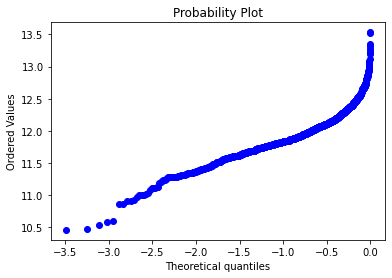

In [12]:
stats.probplot(df['SalePrice_Log'], plot=plt)

### 결측값 처리
- 결측값을 의미하는 NaN이 아닌 없다라는 의미를 가진 None으로 대체
- 그 외에 결측값들은 평균값으로 대체
- test 데이터는 saleprice가 원래 없기 때문에 빼고 결측값 처리 진행

In [13]:
total = df.isnull().sum().sort_values(ascending=False)

In [14]:
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice_Log,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageFinish,159,0.054471


In [15]:
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

for col in cols_fillna:
  df[col].fillna('None', inplace=True)

In [16]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
SalePrice_Log,1459,0.499829
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
MasVnrArea,23,0.007879
BsmtFullBath,2,0.000685
BsmtHalfBath,2,0.000685
GarageArea,1,0.000343
TotalBsmtSF,1,0.000343
BsmtUnfSF,1,0.000343
BsmtFinSF2,1,0.000343


In [17]:
cols_fillna = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']
for col in cols_fillna:
  df[col].fillna(df[col].mean(), inplace=True)

In [18]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
SalePrice_Log,1459,0.499829
GarageCars,0,0.000000
GarageYrBlt,0,0.000000
GarageType,0,0.000000
FireplaceQu,0,0.000000


In [19]:
df = df.astype({'MSSubClass' : object})

### 다중공선성 처리

1stFlrSF(0.61)-1층 평방피트 / TotalBsmtSF(0.61)-지하 총 평방피트 --------------> 0.82

GrLivArea(0.71)-지상 거실 면적 평방 피트 / TotRmsAbvGra(0.53)-지하층 위의 모든 방 (욕실 제외) -- 0.83

GarageYrBit(0.49)-차고 지어진 연도 / YearBuilt(0.52)-건물 지어진 연도 ------> 0.83

GarageCars(0.64)-차량 수용 가능 차고 크기 / GarageArea(0.62)-차고 평방피트 ----> 0.88

1, 3은 두 변수의 합쳐서 새로운 파생변수를 만들고, 2와 4는 target과의 상관계수가 낮은 변수들을 삭제하겠습니다.

In [20]:
df.drop('TotRmsAbvGrd', axis = 1, inplace = True)
df.drop('GarageArea', axis = 1, inplace = True)

In [21]:
# 1stFlrSF + TotalBsmtSF= 1stBsSF(1층 피트 + 지하 피트)
df['TotalSF'] = df['1stFlrSF'] + df['TotalBsmtSF'] 
df.drop('1stFlrSF', axis = 1, inplace=True)
df.drop('TotalBsmtSF', axis = 1, inplace=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,train,SalePrice_Log,TotalSF
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,GasA,Ex,Y,SBrkr,854,0,1710,1.0,0.0,2,1,3,1,Gd,Typ,0,None,Attchd,2003.0,RFn,2.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,1,12.247699,1712.0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,GasA,Ex,Y,SBrkr,0,0,1262,0.0,1.0,2,0,3,1,TA,Typ,1,TA,Attchd,1976.0,RFn,2.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,1,12.109016,2524.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,GasA,Ex,Y,SBrkr,866,0,1786,1.0,0.0,2,1,3,1,Gd,Typ,1,TA,Attchd,2001.0,RFn,2.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,1,12.317171,1840.0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,GasA,Gd,Y,SBrkr,756,0,1717,1.0,0.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,1998.0,Unf,3.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,1,11.849405,1717.0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,GasA,Ex,Y,SBrkr,1053,0,2198,1.0,0.0,2,1,4,1,Gd,Typ,1,TA,Attchd,2000.0,RFn,3.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,1,12.429220,2290.0


In [22]:
# GarageYrBlt + YearBuilt = HouseGarageAge
df['HouseGarageBuilt'] = df['YearBuilt'] + df['GarageYrBlt'] 
df.drop('GarageYrBlt', axis = 1, inplace=True)
df.drop('YearBuilt', axis = 1, inplace=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,train,SalePrice_Log,TotalSF,HouseGarageBuilt
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,GasA,Ex,Y,SBrkr,854,0,1710,1.0,0.0,2,1,3,1,Gd,Typ,0,None,Attchd,RFn,2.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,1,12.247699,1712.0,4006.0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,GasA,Ex,Y,SBrkr,0,0,1262,0.0,1.0,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,2.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,1,12.109016,2524.0,3952.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,GasA,Ex,Y,SBrkr,866,0,1786,1.0,0.0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,2.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,1,12.317171,1840.0,4002.0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,GasA,Gd,Y,SBrkr,756,0,1717,1.0,0.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,3.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,1,11.849405,1717.0,3913.0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,GasA,Ex,Y,SBrkr,1053,0,2198,1.0,0.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,3.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,1,12.429220,2290.0,4000.0


In [23]:
corr = df.corr()["SalePrice_Log"]
corr_abs = corr.abs()

numerical_corr = corr_abs.sort_values(ascending=False)
numerical_corr

SalePrice_Log       1.000000
OverallQual         0.817185
GrLivArea           0.700927
GarageCars          0.680625
TotalSF             0.634207
FullBath            0.594771
HouseGarageBuilt    0.581215
YearRemodAdd        0.565608
Fireplaces          0.489450
MasVnrArea          0.429498
BsmtFinSF1          0.372023
LotFrontage         0.335555
WoodDeckSF          0.334135
OpenPorchSF         0.321053
2ndFlrSF            0.319300
HalfBath            0.313982
LotArea             0.257320
BsmtFullBath        0.236224
BsmtUnfSF           0.221985
BedroomAbvGr        0.209043
EnclosedPorch       0.149050
KitchenAbvGr        0.147548
ScreenPorch         0.121208
PoolArea            0.069798
MoSold              0.057330
3SsnPorch           0.054900
LowQualFinSF        0.037963
YrSold              0.037263
OverallCond         0.036868
MiscVal             0.020021
Id                  0.017942
BsmtHalfBath        0.005149
BsmtFinSF2          0.004832
train                    NaN
Name: SalePric

In [24]:
high_corr_features = corr_abs.index[corr_abs.values >= 0.5]

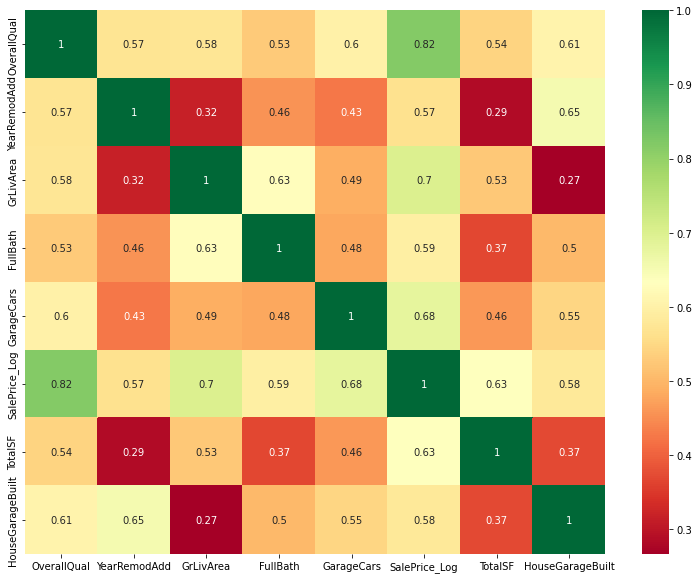

In [25]:
plt.figure(figsize=(13,10))
corr_heatmap = sns.heatmap(df[high_corr_features].corr(), annot=True,cmap="RdYlGn")

### 결론
사용할 수치형 변수 : OverallQual, YearRemodAdd, GrLivArea, FullBath, GarageCars, TotalSF, HouseGarageBuilt

In [26]:
numerical_columns_df = df[['OverallQual', 'YearRemodAdd', 'GrLivArea', 'FullBath', 'GarageCars', 'TotalSF', 'HouseGarageBuilt', 'train', 'SalePrice_Log']]

### nominal_features와 ordinal_features 구분

https://drive.google.com/file/d/1RziGvMbvcf1FyjvEB_ofSZjkTSOBXbh-/view?usp=sharing <참고>

In [27]:
nominal_features = [
    'MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'SaleType', 
    'SaleCondition','GarageType', 'Alley', 'Fence', 'MiscFeature', 'Electrical' , 'Functional'
]

ordinal_features = [
    'LotShape', 'Utilities', 'LandSlope', 'ExterQual', 
    'ExterCond', 'HeatingQC', 'CentralAir', 'KitchenQual', 'PavedDrive', 
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
    'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC'
]

In [28]:
nominal_dummies = pd.get_dummies(df[nominal_features])
nominal_dummies

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Alley_Grvl,Alley_None,Alley_Pave,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_None,Functional_Sev,Functional_Typ
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1

In [29]:
data = pd.concat([numerical_columns_df, nominal_dummies], axis = 1,sort=False)
data.head()

,OverallQual,YearRemodAdd,GrLivArea,FullBath,GarageCars,TotalSF,HouseGarageBuilt,train,SalePrice_Log,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Alley_Grvl,Alley_None,Alley_Pave,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_None,Functional_Sev,Functional_Typ
0,7,2003,1710,2,2.0,1712.0,4006.0,1,12.247699,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,6,1976,1262,2,2.0,2524.0,3952.0,1,12.109016,1,0

### ordinary_features을 수치형 변수로 나타내기 위하여 서열로 인코딩

In [30]:
rating = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

ordinal_encoding = {
    'LotShape': {'None': 0, 'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, 
    'Utilities': {'None': 0, 'ElO': 1, 'NoSeWa': 2, 'NoSeWr': 3, 'AllPub': 4}, 
    'LandSlope': {'None': 0, 'Gtl': 1, 'Mod': 2, 'Sev': 3}, 
    'ExterQual': rating, 
    'ExterCond': rating, 
    'BsmtQual': rating, 
    'BsmtCond': rating, 
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}, 
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}, 
    'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}, 
    'HeatingQC': rating, 
    'CentralAir': {'None': 0, 'N': 1, 'Y': 2}, 
    'KitchenQual': rating, 
    'FireplaceQu': rating, 
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}, 
    'GarageQual': rating, 
    'GarageCond': rating, 
    'PavedDrive': {'None': 0, 'N': 1, 'P': 2, 'Y': 3}, 
    'PoolQC': rating
}

In [31]:
ordinal_dummies = df[ordinal_features].replace(ordinal_encoding)

In [32]:
result = pd.concat([data, ordinal_dummies], axis = 1,sort=False)
result.head()

,OverallQual,YearRemodAdd,GrLivArea,FullBath,GarageCars,TotalSF,HouseGarageBuilt,train,SalePrice_Log,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Alley_Grvl,Alley_None,Alley_Pave,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_None,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_None,Functional_Sev,Functional_Typ,LotShape,Utilities,LandSlope,ExterQual,ExterCond,HeatingQC,CentralAir,KitchenQual,PavedDrive,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC
0,7,2003,1710,2,2.0,1712.0,4006.0,1,12.247699,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

### train과 test로 분리

In [33]:
train_df = result[result['train'] == 1]
train_df = train_df.drop(['train',],axis=1)


test_df = result[result['train'] == 0]
test_df = test_df.drop(['SalePrice_Log'],axis=1)
test_df = test_df.drop(['train',],axis=1)

In [34]:
target= train_df['SalePrice_Log']
train_df = train_df.drop(['SalePrice_Log'],axis=1)

# test

Text(0, 0.5, 'score')

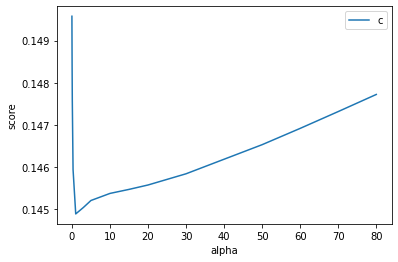

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

y_reg = target
one_hot_encoding_train = train_df
one_hot_encoding_test = test_df

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, one_hot_encoding_train, y_reg, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(one_hot_encoding_train, y_reg)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)
    
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

In [38]:
alphas_alt = [9,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10,10.1,10.2]

ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds)).fit(one_hot_encoding_train, y_reg)

print("Ridge rmse : ",cv_rmse(ridge_model2).mean())

Ridge rmse :  0.14540262224124043


In [39]:
print("Best of alpha in ridge model :" ,ridge_model2.steps[1][1].alpha_)

Best of alpha in ridge model : 9.0


[Text(0.5, 0, 'Penalized Regression Coefficients')]

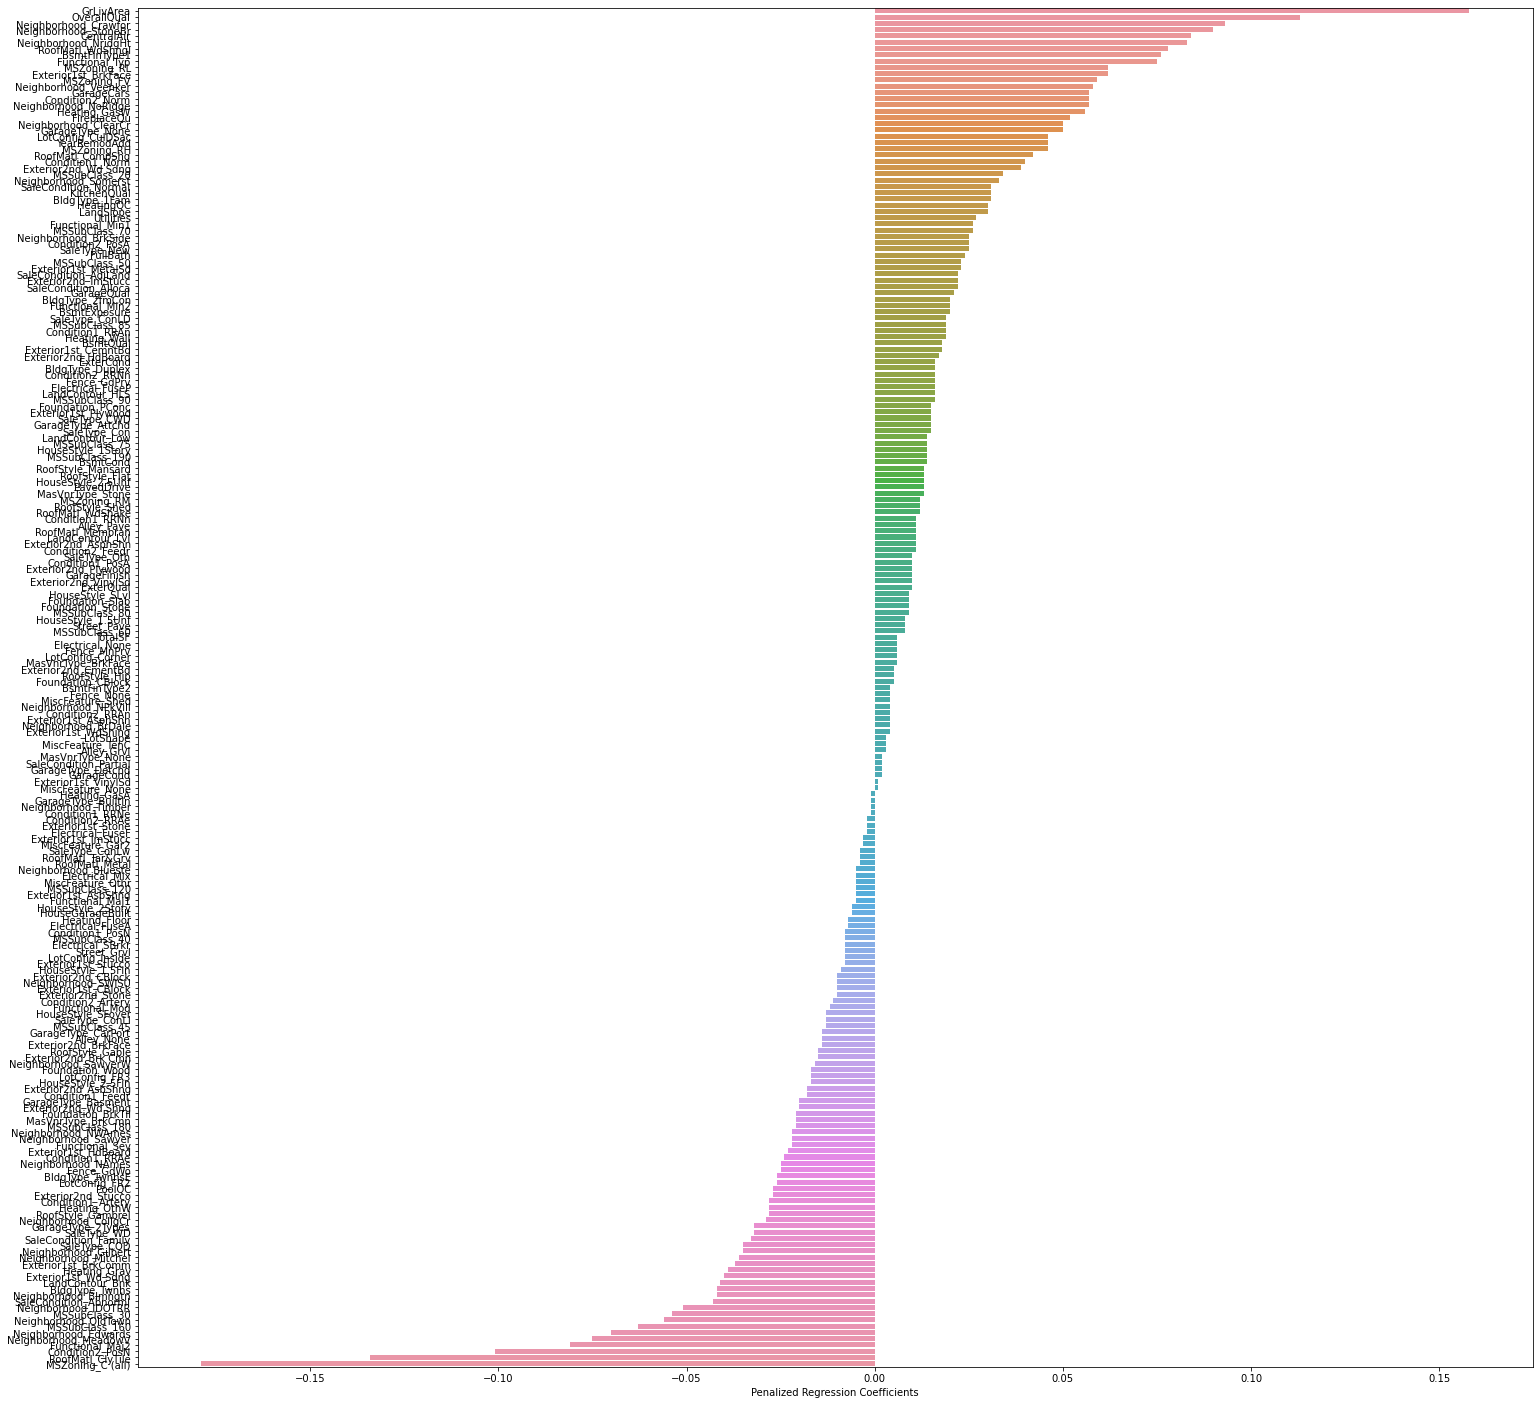

In [40]:
ridge_coef = pd.DataFrame(np.round_(ridge_model2.steps[1][1].coef_, decimals=3), 
one_hot_encoding_test.columns, columns = ["penalized_regression_coefficients"])
# remove the non-zero coefficients
ridge_coef = ridge_coef[ridge_coef['penalized_regression_coefficients'] != 0]
# sort the values from high to low
ridge_coef = ridge_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# plot the sorted dataframe
fig = plt.figure(figsize = (25,25))
ax = sns.barplot(x = 'penalized_regression_coefficients', y= ridge_coef.index , 
data=ridge_coef)
ax.set(xlabel='Penalized Regression Coefficients')

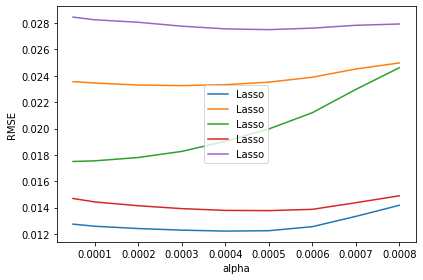

In [41]:
from sklearn.linear_model import LassoCV

alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(one_hot_encoding_train, y_reg)
scores = lasso_model2.steps[1][1].mse_path_

plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [42]:
print("Best of alpha in lasso model :",lasso_model2.steps[1][1].alpha_)
print("lasso rmse : ",cv_rmse(lasso_model2).mean())

Best of alpha in lasso model : 0.0005
lasso rmse :  0.14235556013080414


[Text(0.5, 0, 'Penalized Regression Coefficients')]

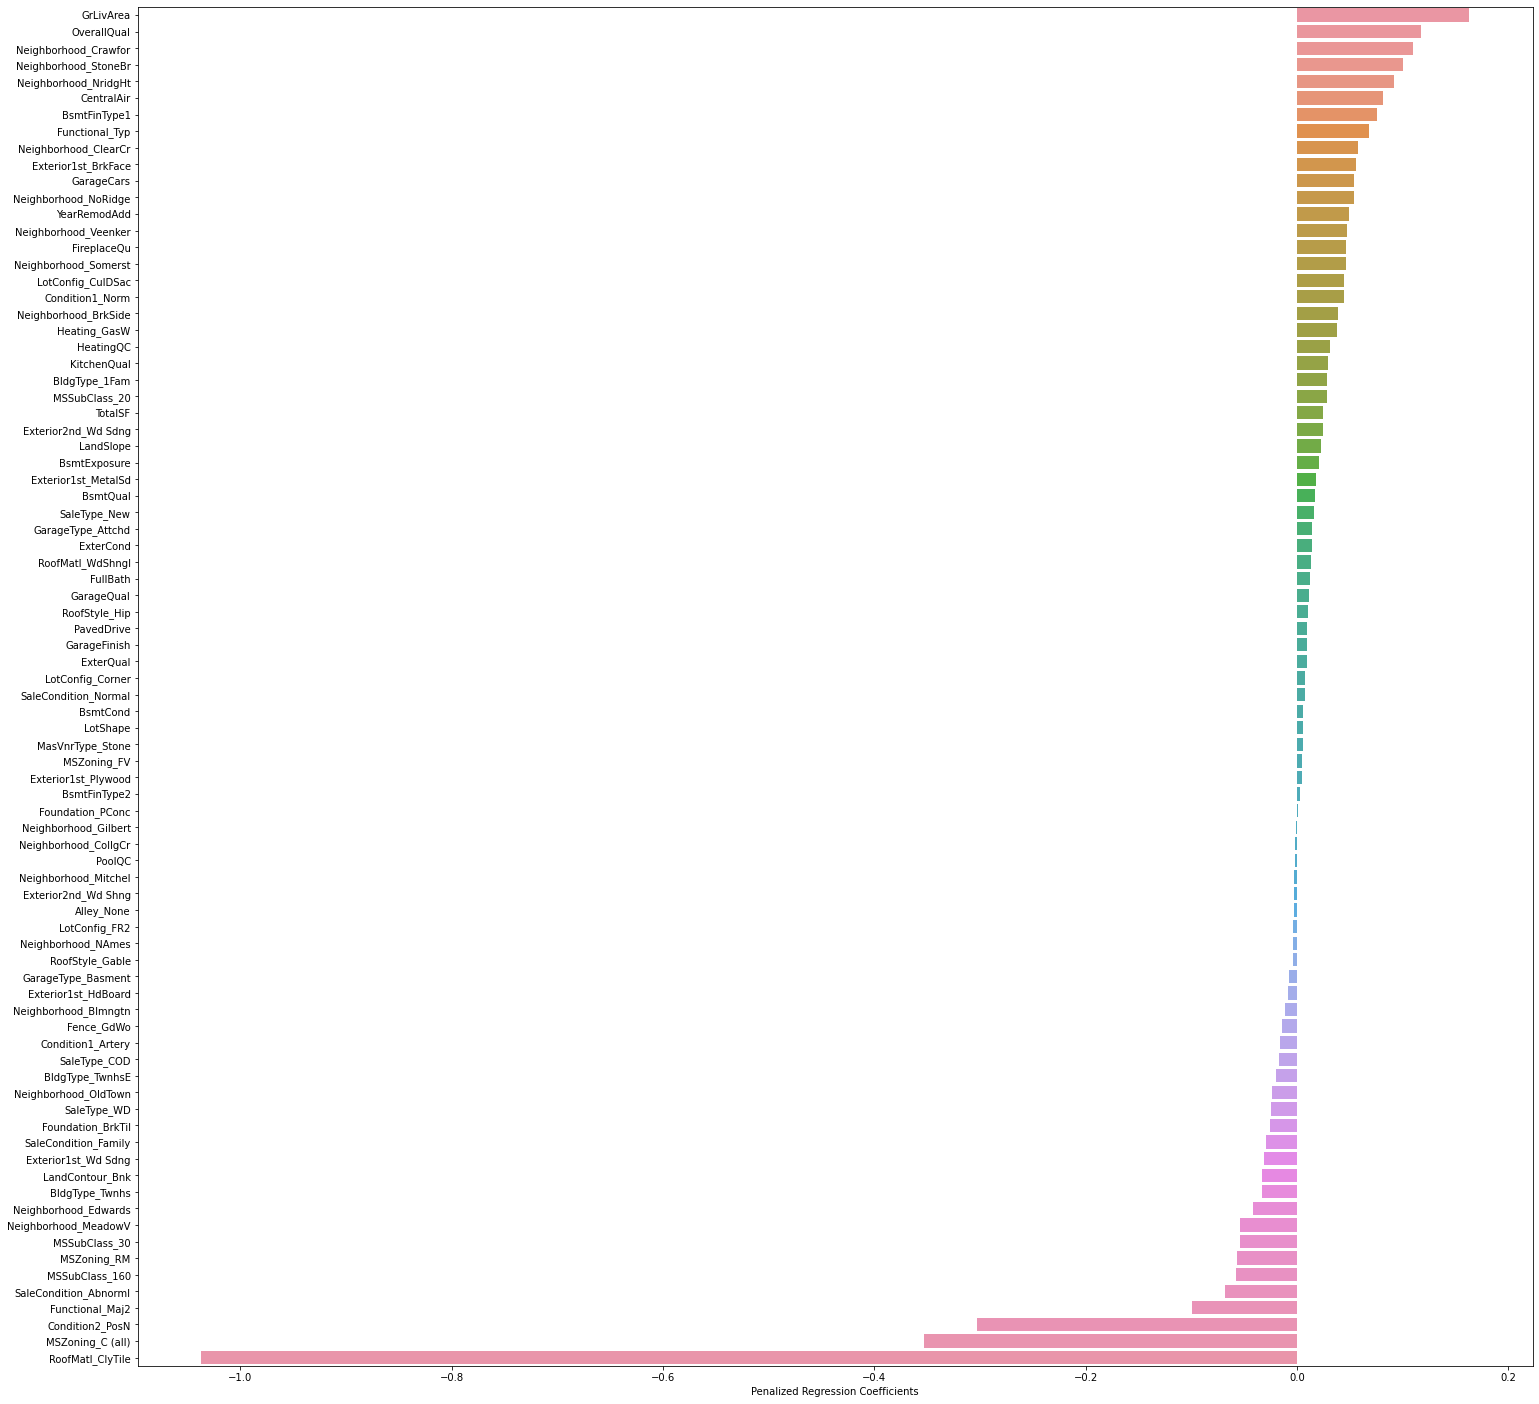

In [43]:
lasso_coef = pd.DataFrame(np.round_(lasso_model2.steps[1][1].coef_, decimals=3), 
one_hot_encoding_test.columns, columns = ["penalized_regression_coefficients"])
# remove the non-zero coefficients
lasso_coef = lasso_coef[lasso_coef['penalized_regression_coefficients'] != 0]
# sort the values from high to low
lasso_coef = lasso_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# plot the sorted dataframe
fig = plt.figure(figsize = (25,25))
ax = sns.barplot(x = 'penalized_regression_coefficients', y= lasso_coef.index , 
data=lasso_coef)
ax.set(xlabel='Penalized Regression Coefficients')

In [44]:
from sklearn.linear_model import ElasticNetCV

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(one_hot_encoding_train, y_reg)
print("elastic model rmse : ",cv_rmse(elastic_model3).mean())

elastic model rmse :  0.14300589348114104


In [45]:
import xgboost as xgb
from xgboost import XGBRegressor

xgb3 = XGBRegressor(learning_rate =0.01, n_estimators=5200, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(one_hot_encoding_train, y_reg)
print("Xgboost model rmse : ",cv_rmse(xgb_fit).mean())

[14:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:56:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgboost model rmse :  0.13247333414958237


In [47]:
import lightgbm as lgb

model = lgb.LGBMRegressor(objective='regression',num_leaves=5,  
                              learning_rate=0.01, n_estimators=5000,  
                              max_bin = 55, bagging_fraction = 0.8,  
                              bagging_freq = 5, feature_fraction = 0.2319,  
                              feature_fraction_seed=9, bagging_seed=9,  
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

lgbm_fit = model.fit(one_hot_encoding_train, y_reg)
print("lightgbm model rmse : ",cv_rmse(model).mean())

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[L

In [48]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = one_hot_encoding_test.columns
feature_importance_df["importance"] = model.feature_importances_

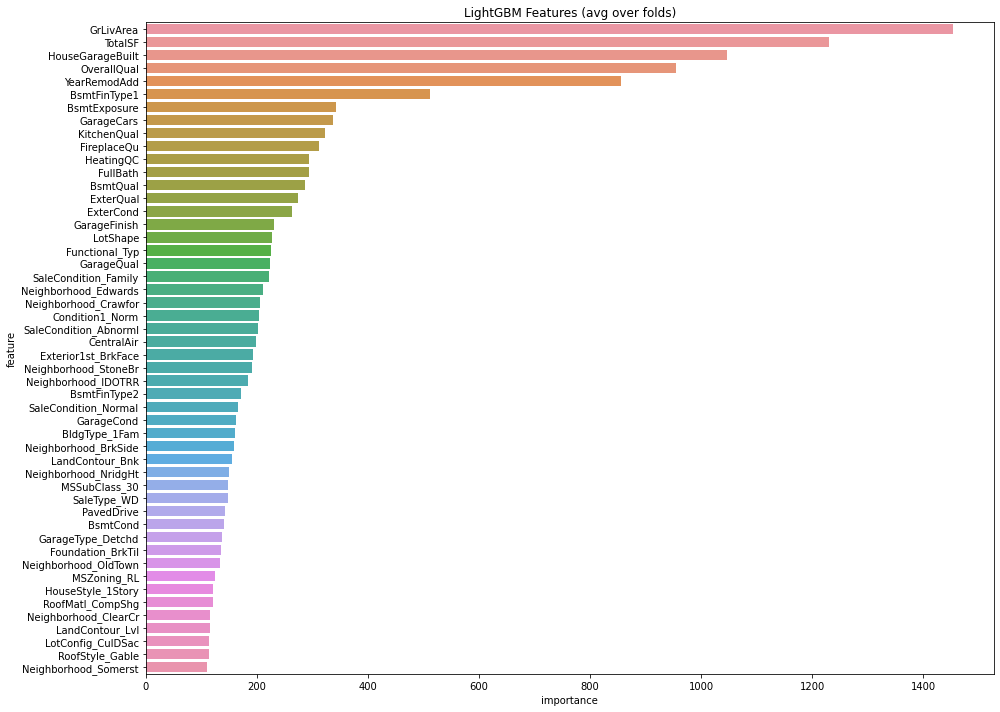

In [49]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [50]:
train_ridge_preds = ridge_model2.predict(one_hot_encoding_train)
train_lasso_preds = lasso_model2.predict(one_hot_encoding_train)
train_elastic_preds = elastic_model3.predict(one_hot_encoding_train)
train_xgb_preds = xgb_fit.predict(one_hot_encoding_train)
train_lgbm_preds = lgbm_fit.predict(one_hot_encoding_train)

stackX = pd.DataFrame(np.transpose(np.array([train_ridge_preds,train_lasso_preds,train_elastic_preds,train_xgb_preds,train_lgbm_preds])))

model = lgb.LGBMRegressor(objective='regression',num_leaves=5,  
                              learning_rate=0.01, n_estimators=4500,  
                              max_bin = 55, bagging_fraction = 0.8,  
                              bagging_freq = 5, feature_fraction = 0.2319,  
                              feature_fraction_seed=9, bagging_seed=9,  
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

stack_fit = model.fit(stackX, y_reg)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [51]:
print("lightgbm model rmse : ",cv_rmse(model).mean())

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[L

In [52]:
test_ridge_preds = ridge_model2.predict(one_hot_encoding_test)
test_lasso_preds = lasso_model2.predict(one_hot_encoding_test)
test_elastic_preds = elastic_model3.predict(one_hot_encoding_test)
test_xgb_preds = xgb_fit.predict(one_hot_encoding_test)
test_lgbm_preds = lgbm_fit.predict(one_hot_encoding_test)

In [53]:
test_stackX = pd.DataFrame(np.transpose(np.array([test_ridge_preds,test_lasso_preds,test_elastic_preds,test_xgb_preds,test_lgbm_preds])))
stack_pred = np.expm1(stack_fit.predict(test_stackX))

In [57]:
submission = pd.DataFrame({'Id': df_test["Id"], 'SalePrice': stack_pred})
submission.to_csv('./submission/stacking_submission.csv', index=False)

In [58]:
### Simple Average
average = 0.2*test_ridge_preds + 0.2*test_lasso_preds + 0.2*test_elastic_preds + 0.2*test_xgb_preds + 0.2*test_lgbm_preds
average = np.expm1(average)
submission = pd.DataFrame({'Id': df_test["Id"], 'SalePrice': average})
submission.to_csv('./submission/simpleAVG_submission.csv', index=False)

In [59]:
### Weight Average
weight_average1 = 0.3980767*test_ridge_preds + -0.03065248*test_lasso_preds + 0.12292276*test_elastic_preds + -0.20778906*test_xgb_preds + 0.71743772*test_lgbm_preds
weight_average1 = np.expm1(weight_average1)
submission = pd.DataFrame({'Id': df_test["Id"], 'SalePrice': weight_average1})
submission.to_csv('./submission/weight_average1_submission.csv', index=False)

In [60]:
### Weight Average
weight_average2 = 0.28018685*test_ridge_preds + 0.10355858*test_lasso_preds + 0.1161906*test_elastic_preds + 0.006204816*test_xgb_preds + 0.49386202*test_lgbm_preds
weight_average2 = np.expm1(weight_average2)
submission = pd.DataFrame({'Id': df_test["Id"], 'SalePrice': weight_average2})
submission.to_csv('./submission/weight_average2_submission.csv', index=False)

# test

### 모델링

In [140]:
x_train,x_test,y_train,y_test = train_test_split(train_df,target,test_size=0.3,random_state=0)

In [141]:
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)


lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )

In [142]:
#Fitting
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train,eval_metric='rmse')

[14:16:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [143]:
predict1 = xgb.predict(x_test)
predict = lgbm.predict(x_test)

In [144]:
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict1))))
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict))))

Root Mean Square Error test = 0.1249411169322606
Root Mean Square Error test = 0.13190004746158246


In [145]:
metrics.r2_score(y_test, predict1)

0.8989686494159073

In [146]:
metrics.r2_score(y_test, predict)

0.8874008027956242

In [149]:
xgb.fit(train_df, target)
lgbm.fit(train_df, target,eval_metric='rmse')

[14:18:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [150]:
predict4 = lgbm.predict(test_df)
predict3 = xgb.predict(test_df)
predict_y = (predict3*0.45 + predict4 * 0.55)

In [153]:
result_predict = np.expm1(predict_y)

In [154]:
submission = pd.DataFrame({
        "Id": df_test["Id"],
        "SalePrice": result_predict
    })
submission.to_csv('./submission/FeatureEngineering_submission.csv', index=False)